In [1]:
import ROOT as r
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
print(r.gROOT.GetVersion())

6.36.04


In [2]:
import ROOT as r
import os

BUILD_LIB_PATH = "../build/lib"

# Only load .so libraries in dependency order
libs_to_load = [
  "libanalysis_pipeline_core.so",
  "libunpacker_data_products_core.so",
  "libunpacker_data_products_nalu.so",
]

for lib in libs_to_load:
    path = os.path.join(BUILD_LIB_PATH, lib)
    if os.path.exists(path):
        print(f"Loading {path} ...")
        r.gSystem.Load(path)
    else:
        print(f"Skipping {path}, not found")

Loading /home/jack/cpp_projects/analysis_pipeline_project/apps/midas_file_unpacker_app/build/lib/libanalysis_pipeline_core.so ...
Loading /home/jack/cpp_projects/analysis_pipeline_project/apps/midas_file_unpacker_app/build/lib/libunpacker_data_products_core.so ...
Loading /home/jack/cpp_projects/analysis_pipeline_project/apps/midas_file_unpacker_app/build/lib/libunpacker_data_products_nalu.so ...


In [3]:
# Open file and get tree
DATA_FILE = "../output.root"
f = r.TFile.Open(DATA_FILE)
tree = f.Get("events")

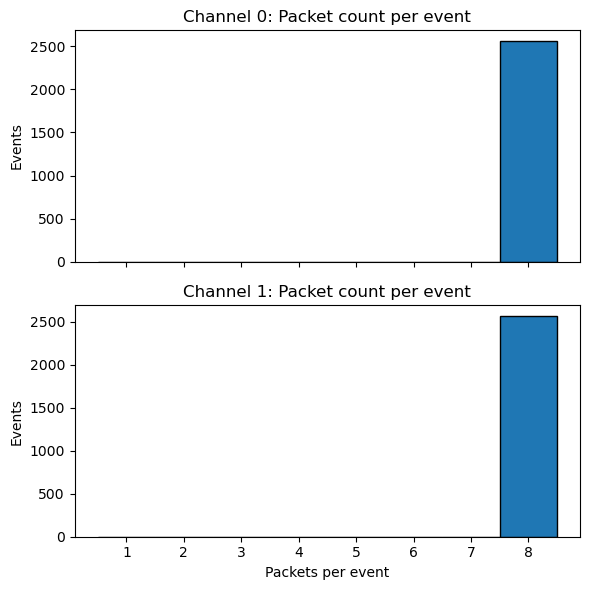

In [4]:
# For each channel, store a list of packet counts (per event)
channel_packet_counts = defaultdict(list)

# Loop over events
for event in tree:
    per_channel_counts = defaultdict(int)
    n_packets = len(event.packets.packets)  # number of packets in this event
    for i in range(n_packets):
        ch = int(event.packets.packets[i].channel)
        per_channel_counts[ch] += 1
    for ch, count in per_channel_counts.items():
        channel_packet_counts[ch].append(count)

# Now make histograms per channel
n_channels = len(channel_packet_counts)
fig, axes = plt.subplots(n_channels, 1, figsize=(6, 3*n_channels), sharex=True)

if n_channels == 1:
    axes = [axes]

for ax, (ch, counts) in zip(axes, sorted(channel_packet_counts.items())):
    ax.hist(counts, bins=range(1, max(counts)+2), edgecolor="black", align="left")
    ax.set_title(f"Channel {ch}: Packet count per event")
    ax.set_ylabel("Events")

axes[-1].set_xlabel("Packets per event")
plt.tight_layout()
plt.show()


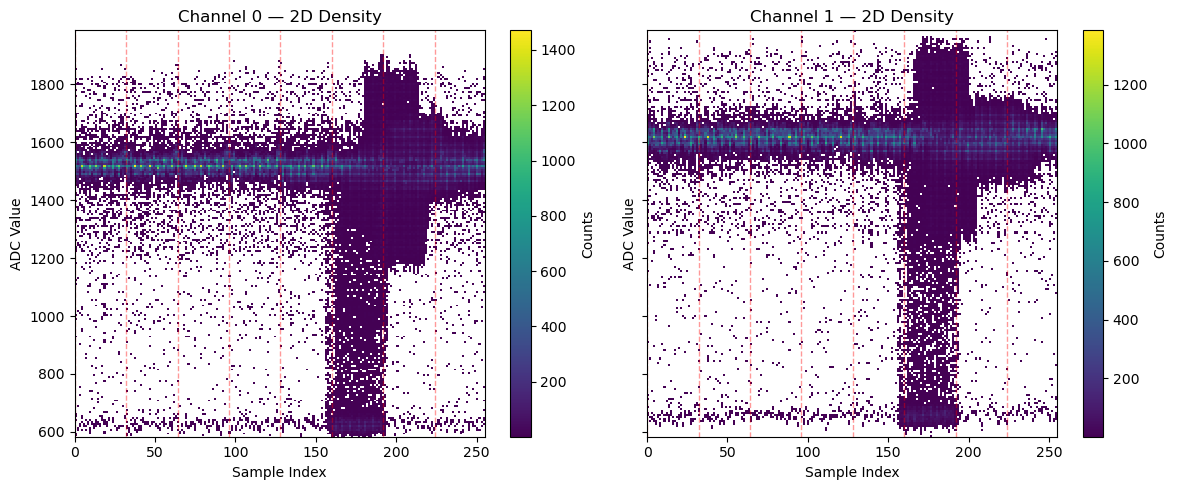

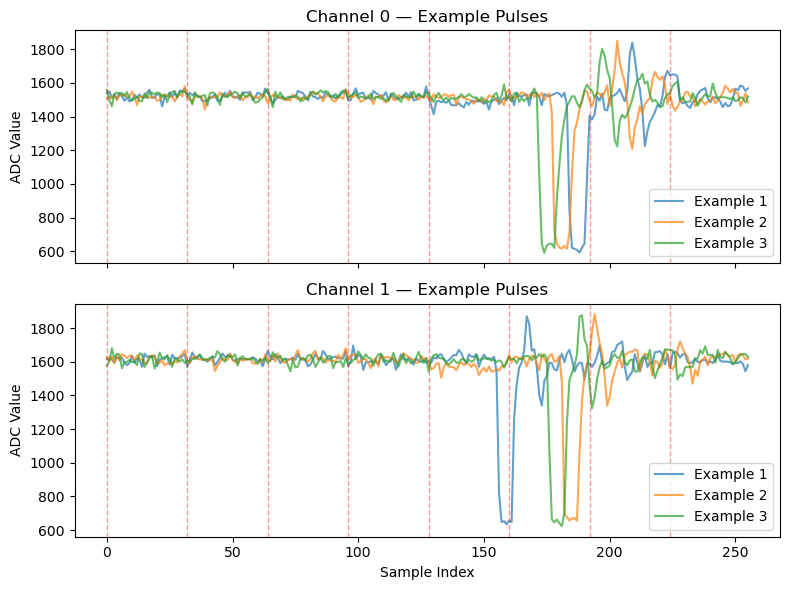

In [5]:
# Accumulate sample/value pairs per channel
channel_samples = defaultdict(list)
channel_values = defaultdict(list)

# Also store a few example waveforms per channel
example_waveforms = defaultdict(list)
max_examples = 3  # how many example pulses per channel

for evt in tree:
    for wf in evt.event.waveforms.waveforms:
        ch = int(wf.channel_num)
        trace = np.array([wf.trace[k] for k in range(len(wf.trace))], dtype=np.int16)

        # Fill 2D hist data
        channel_samples[ch].extend(range(len(trace)))
        channel_values[ch].extend(trace)

        # Save a few examples
        if len(example_waveforms[ch]) < max_examples:
            example_waveforms[ch].append(trace)

f.Close()

# --- Plot 2D hists ---
n_channels = len(channel_samples)
fig, axes = plt.subplots(1, n_channels, figsize=(6*n_channels, 5), sharey=True)

if n_channels == 1:
    axes = [axes]

for ax, ch in zip(axes, sorted(channel_samples.keys())):
    x = np.array(channel_samples[ch])
    y = np.array(channel_values[ch])
    
    hb = ax.hist2d(x, y, bins=[200, 200], cmap="viridis", cmin=1)
    fig.colorbar(hb[3], ax=ax, label="Counts")
    
    # Draw vertical lines every 32 samples
    xmax = x.max()
    for xline in range(0, xmax+1, 32):
        ax.axvline(xline, color="red", linestyle="--", alpha=0.4, linewidth=1)
    
    ax.set_title(f"Channel {ch} — 2D Density")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("ADC Value")

plt.tight_layout()
plt.show()

# --- Plot example pulses ---
fig, axes = plt.subplots(n_channels, 1, figsize=(8, 3*n_channels), sharex=True)

if n_channels == 1:
    axes = [axes]

for ax, ch in zip(axes, sorted(example_waveforms.keys())):
    max_len = max(len(trace) for trace in example_waveforms[ch])
    for i, trace in enumerate(example_waveforms[ch]):
        ax.plot(trace, label=f"Example {i+1}", alpha=0.7)
    
    # Draw vertical lines every 32 samples
    for xline in range(0, max_len, 32):
        ax.axvline(xline, color="red", linestyle="--", alpha=0.4, linewidth=1)
    
    ax.set_title(f"Channel {ch} — Example Pulses")
    ax.set_ylabel("ADC Value")
    ax.legend()

axes[-1].set_xlabel("Sample Index")
plt.tight_layout()
plt.show()
